# Daily Financial News for 6000+ Stocks
### Some Data Understanding an Preparation for Prediction of stockpricse by the Sentiment of Headlines
@author DHR <br>
@author BKN <br>
used Data in this Notebook: 'https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests'

## Requirements

In [1]:
#import basic DataScience Modules
#!! for pip-modul-list to install @see requirements.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
#import basic topic modelling
import re
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import gensim

import pyLDAvis
import pyLDAvis.gensim_models
import pickle 

In [2]:
#import basic visualization
from wordcloud import WordCloud, STOPWORDS
import nltk #tokenization
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DyJay\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [4]:
#imports for generell Cleaning and Merging
import datetime

In [5]:
#imports headline cleaning
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sentistrength import PySentiStr
# from stanfordcorenlp import StanfordCoreNLP
# nlp = StanfordCoreNLP(r'G:\JavaLibraries\stanford-corenlp-full-2018-02-27')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaste\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kaste\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
#import basic api requirements
from polygon import RESTClient
import time
from dotenv import load_dotenv
load_dotenv()

def unique(l):
    ## list of only the unique values from a given list
    x = np.array(l)
    return np.unique(x)

In [13]:
#Load Data
data = pd.read_csv('../data/raw_analyst_ratings.csv')
#colums: id,headline,url,publisher,date,stock

## Data Understanding

Without Data Cleaning

In [14]:
#first Look
print(data.columns)
data.sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


,id,headline,url,publisher,date,stock
1095936,1101376,Repros Names Dr. Larry Dillaha Permanent CEO,https://www.benzinga.com/news/management/17/04...,Paul Quintaro,2017-04-10 00:00:00,RPRX
21807,22309,"8 Stocks To Watch For January 28, 2019",https://www.benzinga.com/news/earnings/19/01/1...,Lisa Levin,2019-01-28 00:00:00,ADBE
1055161,1060373,42 Stocks Moving In Monday's Mid-Day Session,https://www.benzinga.com/news/18/06/11895102/4...,Lisa Levin,2018-06-18 00:00:00,QUAD
817082,821295,Manulife Financial Q2 EPS $0.72 Beats $0.5 Est...,https://www.benzinga.com/news/earnings/19/08/1...,Benzinga Newsdesk,2019-08-07 00:00:00,MFC
48016,48621,Ashford Prime Pleases With Sessa's Decision To...,https://www.benzinga.com/news/16/03/7716657/as...,Paul Quintaro,2016-03-15 00:00:00,AHP
472122,474673,Analyst: Ford Salaried Job Cuts May Be Part Of...,https://www.benzinga.com/analyst-ratings/analy...,Dave Royse,2019-05-21 00:00:00,F
307563,309297,CSX Q4 Earnings Preview,https://www.benzinga.com/news/earnings-preview...,Benzinga Newsdesk,2019-01-16 00:00:00,CSX


In [ ]:
#statistics
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))

In [ ]:
data.count()

In [ ]:
stock = data.groupby("stock")
stock.sample()

In [ ]:
stock.describe()

### Data Visualization

In [ ]:
# BoxPlot of Stocks
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

In [ ]:
# BocPlot of Date
data['date'].value_counts().plot.box(vert=False, figsize=(30,10))

In [ ]:
# Number of Headlines by Stock
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False)[0:6204].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

In [ ]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False)[0:1000].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")

#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

In [ ]:
date_withYear = data.assign(year = lambda dataframe: dataframe['date'].map(lambda date: date[0:4]))

In [ ]:
print("Der Datensatz erstreckt sich über einen Datumsspanne vom "+ data['date'].min()[0:10] +" bis zum "+ data['date'].max()[0:10] +"\nDabei besteht der Datensatz aus "+ str(data.headline.count()) + " Einträgen")

In [ ]:
# Number of Date by Year
year = date_withYear.groupby("year")

plt.figure(figsize=(30,10))
year.size().plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Year")
plt.ylabel("Number of Healines")

In [ ]:
import statistics

print(statistics.mean(year.size()))

In [ ]:
# Termdocument Matrix

# all headlines as String in List
docs = []
for headline in data.headline:
    docs.append(headline)
docs = docs[0:1000]

vec = CountVectorizer()
X = vec.fit_transform(docs)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(df)

# !! TDM just useful for stemmend and removed Stopwords dataset

#### Wordclouds before Data Cleaning

WorldCloud over all Stocks, Top 50 Words:


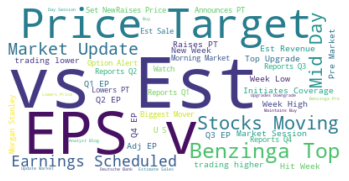

In [4]:
# Wordcloud for all Headlines

#combine all headlines to one text
text = " ".join(headline for headline in data.headline)
maxWords = 50
#wordcloud
#!! No Stopword removal
# stopwords = STOPWORDS
# stopwords.update(["Benzinga", "Stocks", "vs", "Est", "EPS"])
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text)

#plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud.png")

WorldCloud for Random Stock: SVA, Top 50 Words:


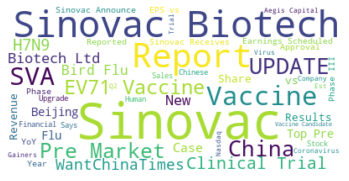

In [7]:
# Wordcloud for one Stock

#combine all headlines of one Stock
stockFilter = random.choice(unique(data['stock']))
maxWords = 50
text_SpecificStock = " ".join(headline for headline in data[data["stock"]==stockFilter].headline)

#wordcloud
#!! No Stopword removal
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text_SpecificStock)

#plot
print("WorldCloud for Random Stock: " + stockFilter + ", Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud_stock-"+ stockFilter +".png")

In [ ]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

#### Topic Modelling before Data Cleaning

In [ ]:
# Topic Modelling with topicCount Topics
topicCount = 10

## Necessary Text Cleaning
# Remove punctuation
# data['headline_processed'] = \
# data['headline'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
# data['headline_processed'] = \
# data['headline_processed'].map(lambda x: x.lower())

# stop_words = stopwords.words('english')
# stop_words.extend(['bezinga', 'stock'])

## Necessary Tokenzisation of Sentences to Words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(simple_preprocess(str(sentence), deacc=True))
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) 
#              if word not in stop_words] for doc in texts]


headline = data.headline.values.tolist() #use headline_processed instead of headline for a little bit of DataCleaning
headline_words = list(sent_to_words(headline))
# remove stop words
# headline_words = remove_stopwords(headline_words)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(headline_words)
# Create Corpus
texts = headline_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:
# The Real Topic Modelling
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=topicCount)
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualization of the Topic Modelling

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./app/results_ldavis_prepared_'+str(topicCount))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './app/results_ldavis_prepared_'+ str(topicCount) +'.html')
LDAvis_prepared

### Data Quality

In [13]:
# count all null values in the DataFrame
print("Anzahl von null Werten im gesamten DataFrame: "+str(data.isna().sum().sum()))

Anzahl von null Werten im gesamten DataFrame: 0


In [14]:
# count all dates without time, no need to format in isoFormat
print("Anzahl Zeitstempel ohne konkrete Uhrzeit: "+ str(data['date'].str.count('00:00:00').sum()))

Anzahl Zeitstempel ohne konkrete Uhrzeit: 1351341


In [15]:
# count duplicated
print("Anzahl Doppelten Einträgen: "+ str(data.duplicated().sum()))

Anzahl Doppelten Einträgen: 0


## Data Preparation

### Clean

#### Date Cleaning

In [9]:
# format datetime to date
data = data.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

# delete all rows older than 2years, because of API and Performance
data = data.drop(data[data.date < '2019-08-21'].index)


In [10]:
# clean the Stocks
# Remove Rows with Stocks that occur less than occ times
occ = 0
data = data[data.groupby('stock').stock.transform(len) > occ]

In [11]:
print("Der Datensatz erstreckt sich nun über einen Datumsspanne vom "+ data['date'].min() +" bis zum "+ data['date'].max() +"\nDabei besteht der Datensatz jetzt aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich nun über einen Datumsspanne vom 2019-08-21 bis zum 2020-06-11
Dabei besteht der Datensatz jetzt aus 164698 Einträgen


#### Headline Cleaning & Pre-Processing
Hier wird nochmal speziell jede einzelene Headline den typischen pre-processing Schritten unterzogen

In [12]:
#daten nochmal neu laden falls reset
data = pd.read_csv('../data/raw_analyst_ratings.csv')


In [42]:
data.sample()

,Unnamed: 0,headline,url,publisher,date,stock
14,14,Agilent Technologies Q2 Adj. EPS $0.71 Beats $...,https://www.benzinga.com/news/earnings/20/05/1...,Benzinga Newsdesk,2020-05-21 00:00:00,A


In [43]:
#Headlines in lowercase konvertieren

data['headline_cleaned'] = data['headline'].apply(lambda headline: headline.lower())

In [44]:
data.sample(10)

,Unnamed: 0,headline,url,publisher,date,stock,headline_cleaned
705,705,"UBS Initiates Agilent Technologies at Buy, $43 PT",https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-10-24 00:00:00,A,"ubs initiates agilent technologies at buy, $43 pt"
483,483,"George A. Scangos, Ph.D., of Biogen Idec to Jo...",https://www.benzinga.com/news/14/03/4403849/ge...,Eddie Staley,2014-03-19 00:00:00,A,"george a. scangos, ph.d., of biogen idec to jo..."
67,67,Wells Fargo Initiates Coverage On Agilent Tech...,https://www.benzinga.com/news/20/01/15090063/w...,Benzinga_Newsdesk,2020-01-08 00:00:00,A,wells fargo initiates coverage on agilent tech...
697,697,Bank of America Upgrades Agilent Technologies ...,https://www.benzinga.com/analyst-ratings/upgra...,Joe Young,2011-11-15 00:00:00,A,bank of america upgrades agilent technologies ...
377,377,"Bruker Corp Has 'Great Story,' But It's Not Ti...",https://www.benzinga.com/analyst-ratings/analy...,Jim Swanson,2015-09-15 00:00:00,A,"bruker corp has 'great story,' but it's not ti..."
155,155,Agilent Technologies Option Alert: Mar 15 $75 ...,https://www.benzinga.com/markets/options/19/01...,Charles Gross,2019-01-29 00:00:00,A,agilent technologies option alert: mar 15 $75 ...
559,559,ISI Group Maintains Buy on Agilent Technologie...,https://www.benzinga.com/news/13/05/3591128/is...,Juan Lopez,2013-05-15 00:00:00,A,isi group maintains buy on agilent technologie...
353,353,Benzinga's Top Upgrades,https://www.benzinga.com/analyst-ratings/upgra...,Monica Gerson,2016-01-07 00:00:00,A,benzinga's top upgrades
360,360,Goldman Sachs Upgrades Agilent Technologies to...,https://www.benzinga.com/news/15/12/6028742/go...,Paul Quintaro,2015-12-08 00:00:00,A,goldman sachs upgrades agilent technologies to...
882,889,Blackstone Group And Glimcher Realty Trust For...,https://www.benzinga.com/markets/company-news/...,Benzinga Staff,2009-11-05 00:00:00,A,blackstone group and glimcher realty trust for...


In [45]:
#POS Tagging
#Beim Part Of Speech Tagging wird geprüft, ob es sich um ein Nomen, Adjevtiv etc. handelt. Das unterstützt das Lammatisieren

def tokenize_post(headline):
    hl_tokenz = word_tokenize(headline)
    hl_post = nltk.pos_tag(hl_tokenz)
    hl_post_result = []
    for word in hl_post:
        if word[1].startswith('NN'):
            hl_post_result.append([word[0], 'n'])
        elif word[1].startswith('JJ'):
            hl_post_result.append([word[0], 'a'])
        elif word[1].startswith('V'):
            hl_post_result.append([word[0], 'v'])
        elif word[1].startswith('R'):
            hl_post_result.append([word[0], 'r'])
        else:
            hl_post_result.append([word[0], ''])
    return hl_post_result


In [46]:
#Tokenization und POS-Tagging durchführen
data['headline_cleaned'] = data['headline'].apply(tokenize_post)

CC coordinating conjunction
CD cardinal digit
DT determiner
EX existential there (like: “there is” … think of it like “there exists”)
FW foreign word
IN preposition/subordinating conjunction
JJ adjective ‘big’
JJR adjective, comparative ‘bigger’
JJS adjective, superlative ‘biggest’
LS list marker 1)
MD modal could, will
NN noun, singular ‘desk’
NNS noun plural ‘desks’
NNP proper noun, singular ‘Harrison’
NNPS proper noun, plural ‘Americans’
PDT predeterminer ‘all the kids’
POS possessive ending parent’s
PRP personal pronoun I, he, she
PRP$ possessive pronoun my, his, hers
RB adverb very, silently,
RBR adverb, comparative better
RBS adverb, superlative best
RP particle give up
TO, to go ‘to’ the store.
UH interjection, errrrrrrrm
VB verb, base form take
VBD verb, past tense took
VBG verb, gerund/present participle taking
VBN verb, past participle taken
VBP verb, sing. present, non-3d take
VBZ verb, 3rd person sing. present takes
WDT wh-determiner which
WP wh-pronoun who, what
WP$ possessive wh-pronoun whose
WRB wh-abverb where, when

In [47]:
#funktionen für  Stopword-removal
    
#Stopwords aus dem NLTK Modul nehmen und entfernen
def remove_stopwords(hl_post_tok_lower):
    stop_words = set(stopwords.words('english')) 

    #hier könnte man noch ein paar eigene Stopwords hinzufügen
    # stop_words.add('')

    filtered_sentence = [word for word in hl_post_tok_lower if not word[0] in stop_words]
    return filtered_sentence

In [48]:
#jetzt das stopword removal durchführen
data['headline_cleaned'] = data['headline_cleaned'].apply(remove_stopwords)

In [49]:
#Hier eine Lemmatisierungsfunktion mit dem WortNetLemmatizer
lemmatizer = WordNetLemmatizer()

#this headline is pos-tagged, tokenzied, lower, and stopwords-removed
def lemmatize(headline):
    lemmatized_output = []
    for word in headline:
        if word[1] == '':
            lemmatized_output.append((lemmatizer.lemmatize(word[0]), word[1]))
        else:
            lemmatized_output.append((lemmatizer.lemmatize(word[0], pos=word[1]), word[1]))

    #Alle Wörter mit weniger als zwei Zeichen weg
    lemmatized_output = [word for word in lemmatized_output if len(word[0]) > 2]

    #Alle Zahlen entfernen
    lemmatized_output = [word for word in lemmatized_output if not word[0].isnumeric()]

    return lemmatized_output

In [50]:
#lemmatization durchführen

#nächste Zeile um daten zu laden
# data_important = pd.read_csv('../data/zwischenergebnis_stopwords_tokenized.csv')
data['headline_cleaned'] = data['headline_cleaned'].apply(lemmatize)

In [51]:
#Mit ein Synset ist eine Liste von den gebräuchlisten Synonymen für ein Wort. zu jedem Wort nehmen wir das gebräuchliste Synonym, um möglichst viele Senitment Werte zu bekommen. 
def getSynset(headline):
    synset_output = []
    for word in headline:
        synsets = wn.synsets(word[0], pos=word[1])
        if len(synsets)>0:
            synset_output.append((synsets[0].name()))
        # wort entfernen wenn kein senitment verfügbar
        # else:
        #     synset_output.append(word[0]+ "." +word[1]+".01")
    return synset_output

In [52]:
#Synset berechnen
data['headline_cleaned'] = data['headline_cleaned'].apply(getSynset)

In [53]:
#calculate sentiment
nltk.download('sentiwordnet')
senti_pos_score = []
senti_neg_score = []

senti_score = []
# senti_obj_score = []

#wir sollten ein eignens Dictionary bauen, dass spezielle Wörter für Aktiennews beinhaltet, wie hit, raise etc. und
def getSentiment(headline):
    senti_pos = 0
    senti_neg = 0
    # senti_obj = 0
    for word in headline:
        #hier erst prüfen, ob das wort in unserem eigenen dictionary ist
        swn_synset = swn.senti_synset(word)
        senti_pos += swn_synset.pos_score()
        senti_neg += swn_synset.neg_score()

    senti_pos_score.append(senti_pos)
    senti_neg_score.append(senti_neg)

    senti_score.append(senti_pos - senti_neg)
    # senti_obj_score.append(swn_synset.obj_score())
    return headline

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\kaste\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [54]:
# calculate Sentiment
data['headline_cleaned'] = data['headline_cleaned'].apply(getSentiment)

In [55]:
# add Sentiment to DataFrame
data['senti_pos_score'] = senti_pos_score
data['senti_neg_score'] = senti_neg_score

data['senti_score'] = senti_score

In [56]:
data.sample(7)

,Unnamed: 0,headline,url,publisher,date,stock,headline_cleaned,senti_pos_score,senti_neg_score,senti_score
106,106,Agilent Technologies shares are trading higher...,https://www.benzinga.com/markets/wiim/19/08/14...,Benzinga Newsdesk,2019-08-14 00:00:00,A,"[technology.n.01, share.n.01, trade.v.01, high...",0.125,0.500,-0.375
98,98,Shares of several healthcare companies are tra...,https://www.benzinga.com/markets/wiim/19/09/14...,Benzinga Newsdesk,2019-09-05 00:00:00,A,"[share.n.01, several.s.01, healthcare.n.01, co...",0.500,0.625,-0.125
874,881,The Health Care Reform Bill: Welcome To The Bi...,https://www.benzinga.com/189402/the-health-car...,Michael Snyder,2010-03-11 00:00:00,A,"[health.n.01, care.n.01, reform.n.01, bill.n.0...",1.250,0.000,1.250
698,698,"US Stock Futures Down Ahead Of Earnings, Econo...",https://www.benzinga.com/news/11/11/2127931/us...,Lisa Levin,2011-11-15 00:00:00,A,"[stock.n.01, future.n.01, down.n.01, net_incom...",0.125,0.000,0.125
710,710,"Financials, Industrials, and Basic Materials S...",https://www.benzinga.com/trading-ideas/long-id...,Benjamin Lee,2011-09-08 00:00:00,A,"[basic.n.01, material.n.01, slide.n.01, stoppi...",0.000,0.000,0.000
548,548,Earnings Expectations For The Week Of August 12,https://www.benzinga.com/news/earnings/13/08/3...,Nelson Hem,2013-08-11 00:00:00,A,"[net_income.n.01, expectation.n.01, week.n.01,...",0.000,0.000,0.000
243,243,Agilent Files Civil Lawsuit against Shanghai E...,https://www.benzinga.com/news/17/08/9964556/ag...,Charles Gross,2017-08-23 00:00:00,A,"[file.n.01, lawsuit.n.01, shanghai.n.01, techn...",0.000,0.000,0.000


In [ ]:
#Export as csv for faster access
data.to_csv('../data/analyst_ratings_processed_hl_cleaned.csv', index=False)

### Construct

#### API call to get StockPrices for all stocks that occur more than 10 times
used API : 'https://polygon.io/'
(need timeouts because of max 5 Api calls per Minute)

In [ ]:
# List of Stock Ticker to call
stocks_unique = unique(data['stock'])
print("Es verbleiben "+str(len(stocks_unique))+" eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen")

In [ ]:
# API call with TimeOut (5 per minute)
key = os.environ.get("POLYGON_IO_API_KEY")
apiResults = []
apiCount = 0

for s in stocks_unique:
    # the API only response to 2years historical dates
    from_ = '2019-08-21'
    to =  '2020-12-31'

    #The API call
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(s, 1, "day", from_, to, unadjusted=False)
        # save the nessecary attributes of the JSON as List
        if (resp and hasattr(resp, 'results')):
            for result in resp.results:
                dt = datetime.datetime.fromtimestamp(result['t'] / 1000.0).isoformat()
                apiResults.append([s, dt, result['o'], result['h'], result['l'], result['c']])
        else: 
            apiResults.append([s])
            print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___no_Results___")
    apiCount+=1
    print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___success___")
    time.sleep(12)

#save the List-Data as DataFrame
stock_prices = pd.DataFrame(apiResults, columns=['stock', 'date', 'open', 'high', 'low', 'close'])
#save the DataFrame as csv
stock_prices.to_csv('../data/raw_stock_prices.csv', encoding='utf-8', index=False)

In [15]:
#get the API data from the csv to DataFrame
stock_prices = pd.read_csv('../data/raw_stock_prices.csv')

#### Overview of the API Data

Remove Stocks that has no Results from DataFrame Stock_prices and Data

In [ ]:
stock_prices.count()

In [ ]:
stock_prices.sample(7)

In [ ]:
# count NaN rows
nanStocks = stock_prices[stock_prices['open'].isna() & stock_prices['close'].isna()]['stock']
print("Total Count of Stocks with NaN: " + str(len(nanStocks)))

#### Combine DataFrame

open and close price of the Stock

In [ ]:
# remove headlines with NaN stock prices
data = data.drop(data[data['stock'].isin(nanStocks)].index)

# remove NaN stocks
stock_prices = stock_prices.drop(stock_prices[stock_prices.open.isna() & stock_prices.close.isna()].index)

In [ ]:
# format datetime to date
stock_prices = stock_prices.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

In [ ]:
# remove headlines with date that are not covered by the stockprices -> probably Weekend
# datetime.datetime.fromisoformat().weekday() in [5,6]
data = data.drop(data[~data['date'].isin(stock_prices['date'])].index) # ~ means NOT IN

In [ ]:
stock_prices.isna().sum()

In [ ]:
data = pd.merge(data, stock_prices[['stock', 'date', 'open', 'close']], on=['stock', 'date'])

#### Calculate Binary
##### Sentiment and Stockprice change
positive Sentiment = 1;
neutral Sentiment = 0;
negative Sentiment = -1

Stock Price Increase by more than x = 1;
Stock Price doesnt change more than x = 0;
Stock Price Decrease by more than x = -1

In [20]:
x=0.01
def stockDevelopment(row):
    # stock_differenz = row['open'] - row['close']
    quotient = row['close']/row['open']
    if quotient < (1-x):
        return -1
    elif quotient > (1+x):
        return 1
    else: return 0

In [21]:
data["stockPrice_Change"] = data.apply(stockDevelopment, axis=1)

In [5]:
def getBinarySenti(row):
    if row["senti_score"] < 0:
        return -1
    elif row['senti_score'] > 0:
        return 1
    else: return 0

In [6]:
data['senti_Binary'] = data.apply(getBinarySenti, axis=1)

### Format

Datetime Format already done for requesting the API and Merging the DateFrames<br>
No more formating needed

## Export Cleaned and Merged DataFrame

In [22]:
# export final DataSet as csv
data.to_csv('../data/analyst_ratings_processed_final.csv', index=False)

In [2]:
# import final DataSet for Modelling
data = pd.read_csv('../data/analyst_ratings_processed_final.csv')

## Data Understanding: Visualization after Cleaning

#### Overview of the Final DataFrame

In [11]:
print(data.columns)
data.drop(columns=['publisher', 'url']).sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock',
       'headline_cleaned', 'senti_pos_score', 'senti_neg_score', 'senti_score',
       'open', 'close', 'stockPrice_Change', 'senti_Binary'],
      dtype='object')


,id,headline,date,stock,headline_cleaned,senti_pos_score,senti_neg_score,senti_score,open,close,stockPrice_Change,senti_Binary
13699,109049,Shares of several technology companies are tra...,2020-01-28,ATVI,"['share.n.01', 'several.s.01', 'technology.n.0...",0.375,1.750,-1.375,58.79,60.0300,0,-1
90654,801222,"Baird Maintains Outperform on Masco, Lowers Pr...",2019-09-18,MAS,"['lower_berth.n.01', 'monetary_value.n.01', 't...",0.000,0.125,-0.125,40.54,41.4800,0,-1
141073,1246280,Mid-Afternoon Market Update: DexCom Gains Foll...,2019-11-07,TOPS,"['market.n.01', 'update.n.01', 'derive.v.02', ...",0.125,0.000,0.125,37.00,30.7500,-1,1
100884,892731,Shares of several utility companies are tradin...,2020-03-16,NEE,"['share.n.01', 'several.s.01', 'utility.n.01',...",0.125,2.500,-2.375,49.50,50.3425,0,-1
55386,480495,Piper Sandler Downgrades First Commonwealth to...,2020-05-01,FCF,"['piper.n.01', 'downgrade.n.01', 'first.n.01',...",0.000,0.250,-0.250,8.86,8.8000,0,-1
146311,1274599,Stocks That Hit 52-Week Lows On Wednesday,2020-03-18,TWO,"['stock.n.01', 'hit.v.01', 'low.n.01', 'wednes...",0.000,0.000,0.000,7.60,5.6900,-1,0
113312,991211,"MKM Partners Maintains Buy on PDC Energy, Lowe...",2020-03-03,PDCE,"['spouse.n.01', 'bargain.n.02', 'energy.n.01',...",0.500,0.125,0.375,18.56,17.5300,0,1


In [18]:
count_zeroSenti = data[data['senti_score'] == 0.000]['id'].count()
count_noSenti = data[(data['senti_pos_score'] == 0.000) & (data['senti_neg_score'] == 0.000)]['id'].count()
count_Senti = data[data['senti_score'] != 0.000]['id'].count()
count_Senti_neg = data[data['senti_score'] < 0.000]['id'].count()
count_Senti_pos = data[data['senti_score'] > 0.000]['id'].count()
count_eachSenti = data[(data['senti_pos_score'] != 0.000) & (data['senti_neg_score'] != 0.000)]['id'].count()

print("Im folgenden wird die Verteilung des Sentiment-Score über die Headlines genauer betrachtet: \n%d headlines haben einen durchschnittlichen Sentiment von 0, davon haben %d weder einen positiven noch einen negativen Sentiment-Score. \nHingegegen haben %d Headlines einen Sentiment-Score gesetzt der ungleich 0 ist. %d positive, %d negative. Dabei haben %d jeweils positive und negative zu bewertende Wörter." % (count_zeroSenti,count_noSenti,count_Senti,count_Senti_neg,count_Senti_pos,count_eachSenti))

Im folgenden wird die Verteilung des Sentiment-Score über die Headlines genauer betrachtet: 
64456 headlines haben einen durchschnittlichen Sentiment von 0, davon haben 59718 weder einen positiven noch einen negativen Sentiment-Score. 
Hingegegen haben 97022 Headlines einen Sentiment-Score gesetzt der ungleich 0 ist. 45005 positive, 52017 negative. Dabei haben 50671 jeweils positive und negative zu bewertende Wörter.


In [19]:
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))

observations: 161478, features: 12 

unique headlines: 76162, unique stocks: 3722 



<AxesSubplot:>

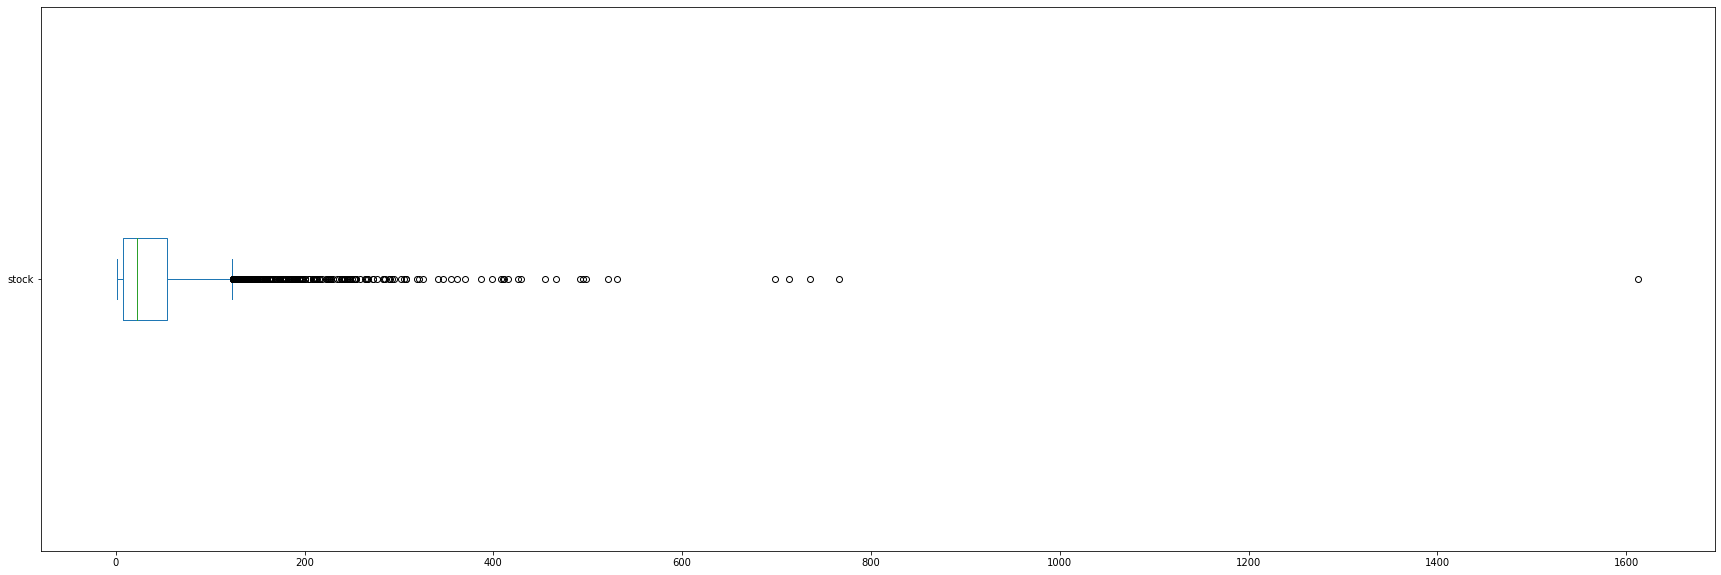

In [20]:
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

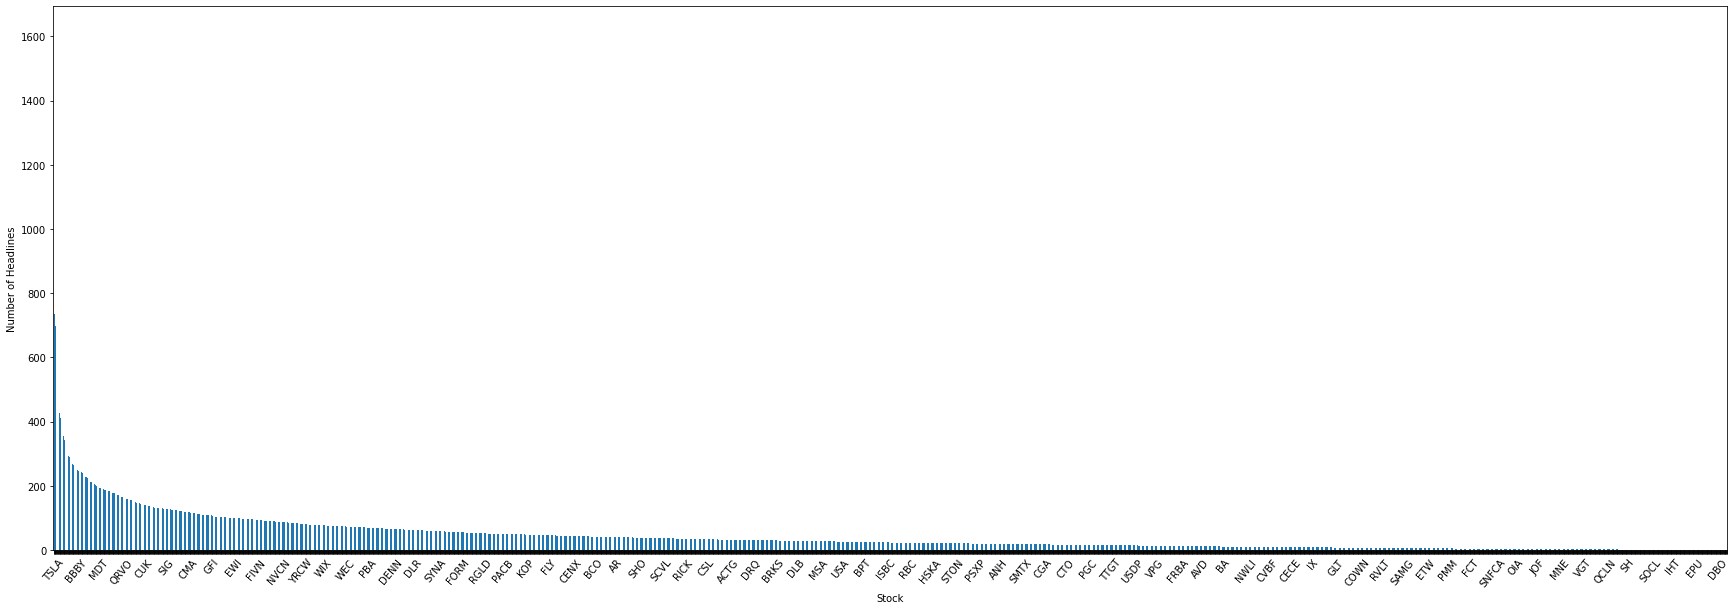

In [21]:
stock = data.groupby("stock")
# Number of Headlines by Stock
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

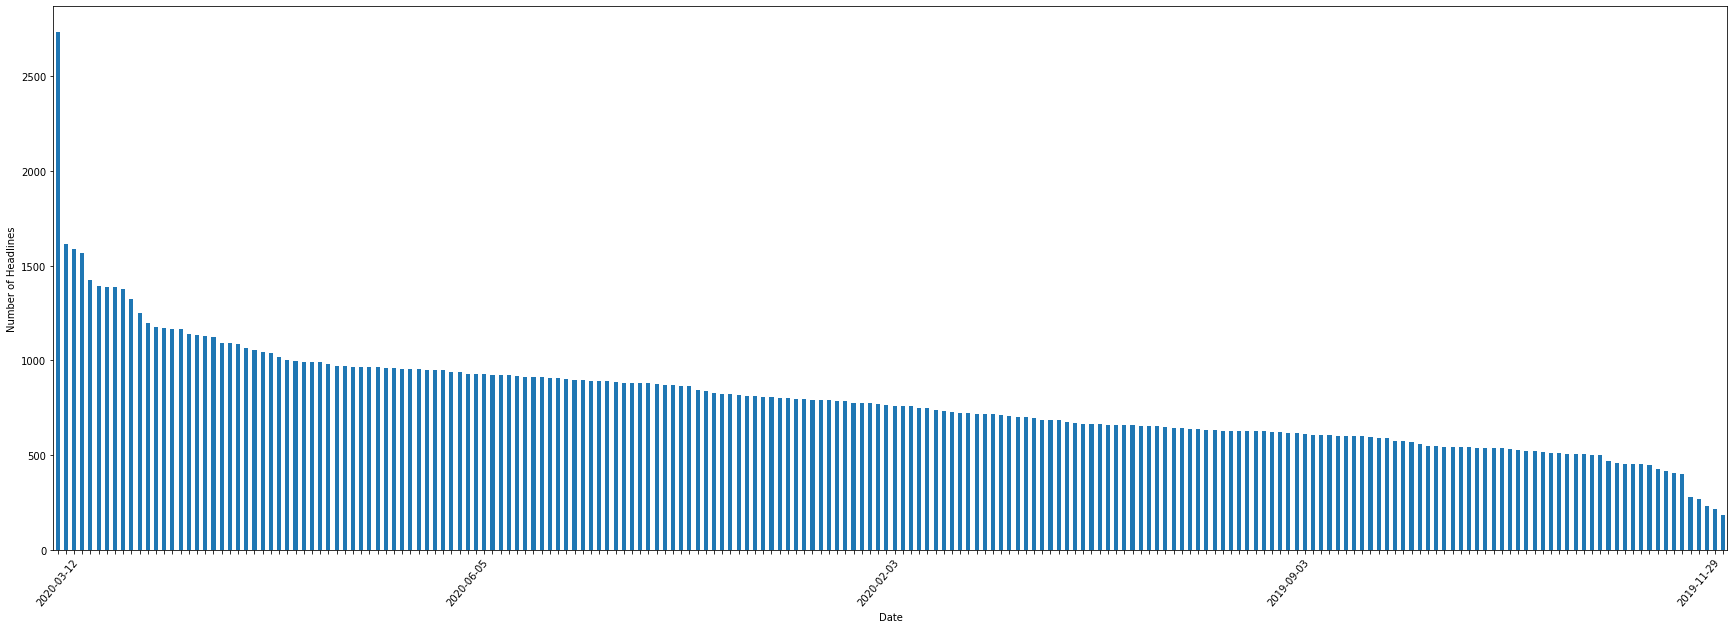

In [22]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")

#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

In [25]:
# Termdocument Matrix

# all headlines as String in List
docs_afterCleaning = []
for headline in data.headline_cleaned:
    docs_afterCleaning.append(' '.join(list(map(lambda s: s.strip()[1:-5].replace('.',''), headline[1:-1].split(',')))))

vec = CountVectorizer()
X = vec.fit_transform(docs_afterCleaning)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(df)

# !! TDM just useful for stemmend and removed Stopwords dataset

MemoryError: Unable to allocate 10.6 GiB for an array with shape (161478, 8832) and data type int64

#### Wordclouds after Data Cleaning

WorldCloud over all Stocks, Top 50 Words:


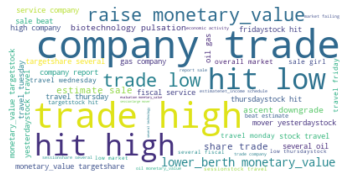

In [26]:
# Wordcloud for all Headlines

#combine all headlines to one text
text_afterCleaning = " "
for headline in data.headline_cleaned:
    text_afterCleaning = text_afterCleaning + ' '.join(list(map(lambda s: s.strip()[1:-5].replace('.',''), headline[1:-1].split(','))))

maxWords = 50
#wordcloud
#No Stopword removal - Stopwords already removed
# stopwords = STOPWORDS
# stopwords.update(["Benzinga", "Stocks", "vs", "Est", "EPS"])
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text_afterCleaning)

#plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud_afterCleaning.png")

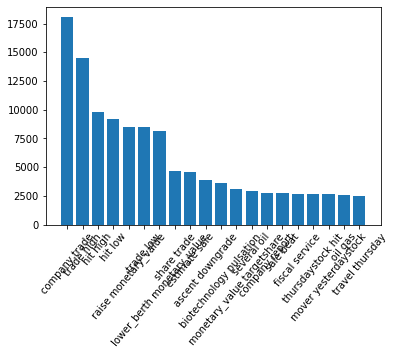

In [27]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text_afterCleaning)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

#### Topic Modelling after Data Cleaning

In [ ]:
# Topic Modelling with topicCount Topics
topicCount = 10

headline_toks = []
for headline in data.headline_cleaned:
    headline_toks.append(list(map(lambda s: s.strip()[1:-5].replace('.',''), headline[1:-1].split(','))))

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(headline_toks)
# Create Corpus
texts = headline_toks
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:
# The Real Topic Modelling
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=topicCount)
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualization of the Topic Modelling

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./app/results_cleaned_ldavis_prepared_'+str(topicCount))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './app/results_cleaned_ldavis_prepared_'+ str(topicCount) +'.html')
LDAvis_prepared